In [1]:
import numpy as np
from core import stagger_FD_coeff as sfci
from core.utils import cholesky_solver
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveSampler
from core.QUBO_solvers import IterSampleSolver
from collections import ChainMap
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

pi = np.pi

In [2]:
v = 2500
h = 10
tao = 0.001
freq_max_set = [100]
M_set = [10]
max_iter_num = 30

# sampler = DWaveSampler(token='',
#                        solver='Advantage_system6.2',
#                        region='na-west-1')
sampler = SimulatedAnnealingSampler()

tra_a0_dict = {}
for M in M_set:
    tra_a0_dict["Tra" + f" M={M}"] = sfci.Taylor_Coef(M)

wang_a0_dict = {}
for M, freq_max in zip(M_set, freq_max_set):
    linear_sys = sfci.Stagger_FD_coeff_3D(v, h, tao, freq_max)
    wang_a0_dict["Wang" + f" M={M}"] = linear_sys.solve(
        M=M,
        alpha=1,
        beta=1,
        max_iter_num=max_iter_num,
        mode_of_construct="lstsq",
        solver=cholesky_solver,
        show_process=False,
    )

qa_a0_dict = {}
for M, freq_max in zip(M_set, freq_max_set):
    linear_sys = sfci.Stagger_FD_coeff_3D(v, h, tao, freq_max)
    sis = IterSampleSolver(
        sampler=sampler,
        x0=np.ones(M) / 100,  # initial vector of Delta a
        num_sample=100,  # 5000
        R=10,
        alpha = 0.1,
        fixed_point=1,
        epsilon=1e-5,
        maxiter=3,  # max iteration in small iteration
        resultMod="lowest_energy",
        num_spin_reversal_transforms=10,
        postprocess=True,
    )
    qa_a0 = linear_sys.solve(
        M=M,
        coeff_vec=sfci.Taylor_Coef(M),
        beta=1,
        max_iter_num=max_iter_num,
        mode_of_construct="direct",
        solver=sis.solve,
        show_process=False,
    )
    qa_a0_dict[f"QA M={M}"] = qa_a0

result_dict = dict(ChainMap(tra_a0_dict, wang_a0_dict, qa_a0_dict))

Current object function value is 15615.820831935027
~~~~~~~~ Start 1 iteration ~~~~~~~~
Current coeff_vec is:
[[ 24.78379428  13.48553039 -12.24538191   3.51181628  -6.59132232
   -2.10008516   9.05702012  -7.49340206   1.79056241   1.41735401]]
Current object function value is 33073229695.009285
~~~~~~~~ Start 2 iteration ~~~~~~~~
Current coeff_vec is:
[[12.47268141  6.68667906 -6.0682989   1.72220085 -3.2601197  -1.06542925
   4.54009874 -3.74942259  0.8986669   0.70666225]]
Current object function value is 2064283433.0073571
~~~~~~~~ Start 3 iteration ~~~~~~~~
Current coeff_vec is:
[[ 6.39473046  3.234019   -2.92814233  0.79578178 -1.56074238 -0.56211203
   2.29249778 -1.87947748  0.45594644  0.34954133]]
Current object function value is 128325893.42212158
~~~~~~~~ Start 4 iteration ~~~~~~~~
Current coeff_vec is:
[[ 3.50960036  1.39920272 -1.25821661  0.26504908 -0.64671693 -0.34218054
   1.18889837 -0.95071602  0.24058645  0.16681553]]
Current object function value is 7852506.49290

d:\OneDrive\OneDrive - mails.ucas.ac.cn\Research\2_Monthly_Report\2024博三下半学期\博士期间第一篇工作\code_for_the_paper\Solution_of_Forward_Operator\core\QUBO_solvers.py:629: UserWarning: 'codingMod' indicates the way bit string to represent a number! It contain three mod, 'p', 'n', 'pn' If not specified, the default Settings will be used
  warnings.warn(



* The sampling time in 1 iteration was: 0.54 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.7272886869763405
* The step size of current iteration:0.9430708991847692

* The sampling time in 2 iteration was: 0.48 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.4931156534476182
* The step size of current iteration:0.9497301168373233

* The sampling time in 3 iteration was: 0.48 s
** The postprocess time is: 0.004 s
* Current Object Function is 0.44556385561974493
Satisfying the termination condition, stop the iteration.
The lowest obj funciton is 0.44556385561974493

Current coeff_vec is:
[[ 1.22602885 -0.10657618  0.02238467  0.00135636 -0.01139966  0.01325326
  -0.01573603  0.01239019 -0.00961867  0.00751629]]
Current object function value is 0.19661344895790794
~~~~~~~~ Start 2 iteration ~~~~~~~~

* The sampling time in 1 iteration was: 0.49 s
** The postprocess time is: 0.008 s
* Current Object Function is 0.8372884243731338
* The step size 

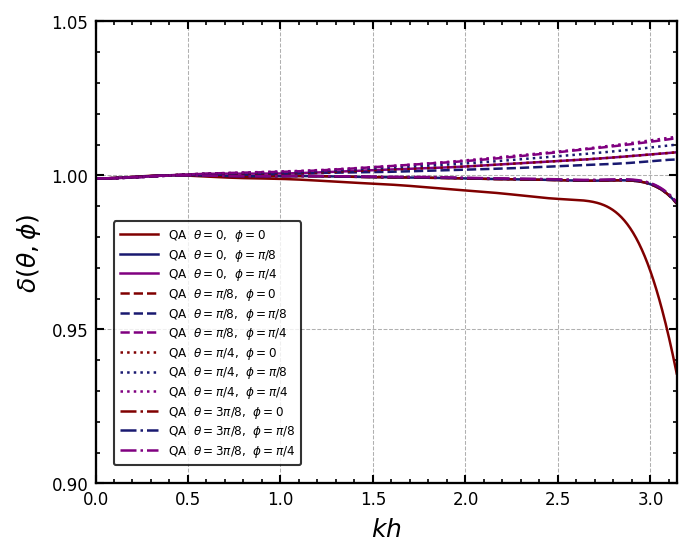

In [6]:
pi = np.pi
v = 2500
h = 10
tao = 0.001
max_iter_num = 20

# 创建王老师方法中定义的线性系统对象
linear_sys = sfci.Stagger_FD_coeff_3D(v, h, tao)

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=150)

lw = 1.1  # linwidth of box
style_set = ["-", "--", ":", "-."]
color_set = ["maroon", "midnightblue", "purple"]
linwith = 1.2
counter_s = 0
counter_c = 0
target = "QA"  # Tra, Wang, QA
for label, coeff in result_dict.items():
    for str_theta, theta in zip(
        ["0", "$\\pi/8$", "$\\pi/4$", "$3\\pi/8$"], [0, pi / 8, pi / 4, 3 * pi / 8]
    ):
        for str_phi, phi in zip(["0", "$\\pi/8$", "$\\pi/4$"], [0, pi / 8, pi / 4]):
            sigma = linear_sys.cal_sigma(
                v * tao / h,
                np.linspace(pi / 1000, pi, 1000),
                coeff,
                theta=theta,
                phi=phi,
            )
            if target in label:
                ax.plot(
                    np.linspace(pi / 1000, pi, 1000),
                    sigma,
                    color=color_set[counter_c],
                    linewidth=linwith,
                    ls=style_set[counter_s],
                    label=target
                    + "  "
                    + f"$\\theta=${str_theta}"
                    + ",  "
                    + f"$\\phi=${str_phi}",
                )

            ax.set_ylim([0.9, 1.05])
            ax.set_xlim([0, 3.142])
            ax.set_ylabel("$\delta(\\theta, \\phi)$", fontsize=12)
            ax.set_xlabel("$kh$", fontsize=12)
            ax.set_xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
            ax.set_yticks([0.9, 0.95, 1.0, 1.05])
            # 设置边框粗细
            ax.spines["left"].set_linewidth(lw)
            ax.spines["top"].set_linewidth(lw)
            ax.spines["right"].set_linewidth(lw)
            ax.spines["bottom"].set_linewidth(lw)

            # 设置主刻度格式
            ax.tick_params(
                top=True,
                right=True,
                which="major",
                direction="in",
                length=4,
                width=1.0,
                colors="black",
                labelsize=8,
            )
            # 设置次刻度格式
            ax.xaxis.set_minor_locator(
                MultipleLocator(0.1)
            )  # 显示子刻度,括号里的是间距
            ax.yaxis.set_minor_locator(MultipleLocator(0.01))
            # ax.xaxis.set_minor_locator(AutoMinorLocator()) #  MultipleLocator(0.2)
            ax.tick_params(
                top=True,
                right=True,
                direction="in",
                which="minor",
                length=2,
                width=0.8,
                colors="black",
            )

            ax.grid(
                visible=True, axis="both", which="major", linestyle="--", linewidth=0.5
            )
            ax.legend(
                title="",
                fontsize="xx-small",
                loc="lower left",
                borderpad=0.5,  # 图例内部留白
                borderaxespad=1.5,  # 图框边界距离坐标轴距离
                labelspacing=0.3,  # 图例条目间距
                edgecolor="black",
                handlelength=3.2,
            )

            counter_c = (counter_c + 1) % 3
        counter_s = (counter_s + 1) % 4

plt.show()
# fig.savefig(f'3D_reuslt_{target}.png', dpi=300)